In [61]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import colormaps as cm
import csv
from pathlib import Path
import glob
import seaborn as sns

In [62]:
def load_drive(E=1.0, smooth=100):
    if E == -1:
        fJ = lambda x: x * (1- np.exp(-smooth * x * x))
        fg = lambda x: 3.04438 * (1 - fJ(x))
    elif E == -2:
        fJ = lambda x: x * (1- np.exp(-32 * x))
        fg = lambda x: 3.04438 * (1 - fJ(x))
    elif E == -3:
        fJ = lambda x: 0.5 + 1.5 * (x - 0.5) - 2 * (x - 0.5) ** 3
        fg = lambda x: 3.04438 * (1 - fJ(x))
    else:
        schedule = np.loadtxt('09-1265A-E_Advantage_system5_4_annealing_schedule.csv', delimiter=",")
        fg = scipy.interpolate.UnivariateSpline(schedule[:, 0], schedule[:, 1] * np.pi * (1 - np.exp(-smooth * schedule[:, 0]**2)) + np.exp(-smooth * schedule[:, 0]**2) * 30, s=0, k=4)
        fJ = scipy.interpolate.UnivariateSpline(schedule[:, 0], schedule[:, 2] * E * np.pi * (1 - np.exp(-smooth * schedule[:, 0]**2)), s=0, k=4)
    return fg, fJ


def get_sc(E):
    gc = 3.04438
    fg, fJ = load_drive(E)
    sc = scipy.optimize.fsolve(lambda s: fg(s) - gc * fJ(s), 0.5)
    return sc[0]


In [63]:
data = {}

for fname in glob.glob("./bias_dwave/**/data*.csv", recursive=True):
    param = fname.split("/")
    hz = float(param[2][3:])
    ta = float(param[3][3:])
    bb = param[5]
    E = float(param[4][2:])
    fieldnames = ["D", "which", "chi", "dt", "Delta", "time", "Ezz", "Ez", "Ex"]
    dtypes =     [int, str, int, float, float, float, float, float, float]
    sf = float(param[6][8:14])
    ind = (hz, ta, E, sf, bb)

    with open(fname, 'r', newline='') as csvfile:
        csvfile.readline()
        data[ind] = []
        for x in csv.DictReader(csvfile, fieldnames=fieldnames, delimiter=";"):
            for fn, typ in zip(fieldnames, dtypes):
                x[fn] = typ(x[fn])
            x["Eng"] = (-2 * x["Ezz"] - float(hz) * x["Ez"])
            data[ind].append(x)

In [64]:
smpls = {}

for fname in glob.glob("./bias_dwave/**/sample*.npy", recursive=True):
    param = fname.split("/")
    param = fname.split("/")
    hz = float(param[2][3:])
    ta = float(param[3][3:])
    bb = param[5]
    E = float(param[4][2:])
    nn = param[6].split("_")
    D = int(nn[1][2:])
    chi = int(nn[2][4:])
    if len(nn) == 5:
        sf = float(nn[4][3:-4])
        ind = (hz, ta, E, sf, D, chi, '16x16')
    else:
        sf = float(nn[4][3:])
        xy = nn[5][:-4]
        ind = (hz, ta, E, sf, D, chi, xy)

    smpls[ind] = np.load(fname, allow_pickle=True)


In [65]:
def get_sf(hz, ta, E):
    sfs = []
    for ind in data:
        #print(ind[:3], (hz, ta, E))
        if ind[:3] == (hz, ta, E):
            sfs.append(ind[3])
    sfs.sort()
    return sfs

In [66]:
def plot_ax(ax, hz, E, val='Ezz', bb='ZZ', in_g=False):
    Dline = {8: ':', 12:'--', 16: "-.", 20: "-"}
    gc = 3.04438
    colors = sns.color_palette("tab20")
    tas = [0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 5.4, 6.3, 7.2, 8.0, 8.3, 9.6, 16.0]
    sc = get_sc(E)

    fg, fJ = load_drive(E, smooth=100)

    for ii, ta in enumerate(tas):
        sfs = get_sf(hz, ta, E)
        dat = {}
        for sf in sfs:
            unique_D = []
            if (hz, ta, E, sf, bb) in data:
                for x in data[hz, ta, E, sf, bb]:
                    if x['D'] not in unique_D:
                        unique_D.append(x['D'])
                        if x['D'] in dat:
                            dat[x['D']].append(x[val])
                        else:
                            dat[x['D']] = [x[val]]
        sff = [float(sf) for sf in sfs]
        for k, v in dat.items():
            if k in [8, 12, 16, 20]:
                sss = np.array(sff[:len(v)])
                if in_g:
                    sss = fg(sss) /  (fJ(sss) * gc)
                line, = ax.plot(sss, np.abs(v), Dline[k], color=colors[ii])
                if k == 12:
                    line.set_label(f"{ta=}")
    #ax.axvline(x=0.4, linestyle=':', color='k')

    ax.set_ylabel(val)
    ax.set_title(f"{hz=} {E=}")
    ax.set_ylim([0, 1.0])
    if in_g:
        ax.set_xlim([0, 2])
        ax.axvline(x=1, linestyle=':', color='k')
        ax.set_xlabel("g / (gc J)")
    else:
        ax.set_xlabel("s")
        ax.axvline(x=sc, linestyle=':', color='k')
        if E < 0:
            ax.set_xlim([0, 1.0])
        else:
            ax.set_xlim([0, 0.6])


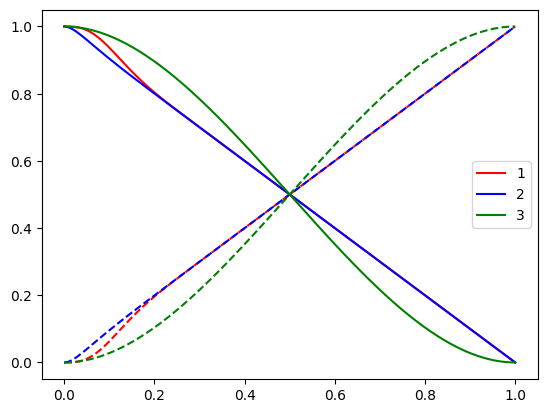

In [51]:
gc = 3.04438
g1, J1 = load_drive(-1)
g2, J2 = load_drive(-2)
g3, J3 = load_drive(-3)
x = np.linspace(0, 1, 1001)
plt.plot(x, g1(x) / gc, '-r', label="1")
plt.plot(x, J1(x), '--r')
plt.plot(x, g2(x) / gc, '-b', label="2")
plt.plot(x, J2(x), '--b')
plt.plot(x, g3(x) / gc, '-g', label="3")
plt.plot(x, J3(x), '--g')
plt.legend()

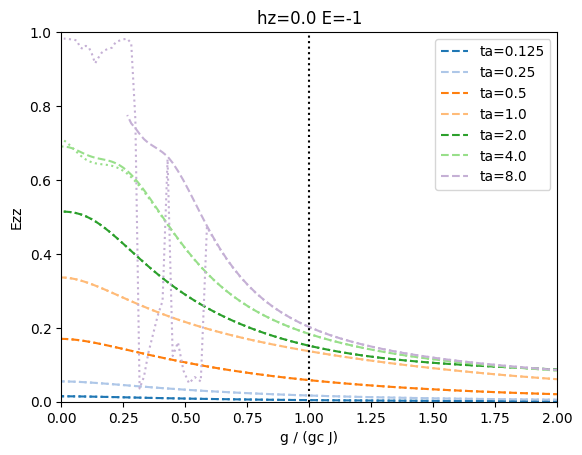

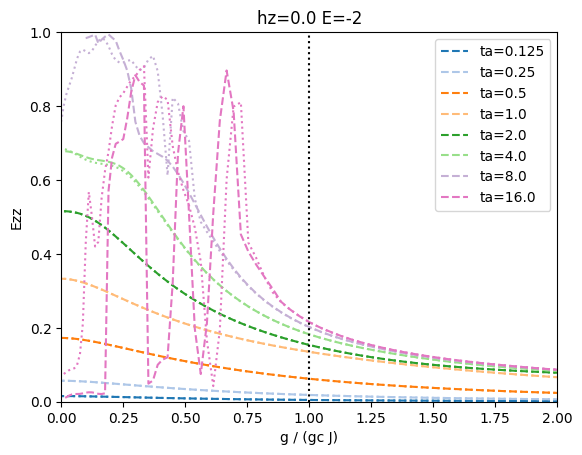

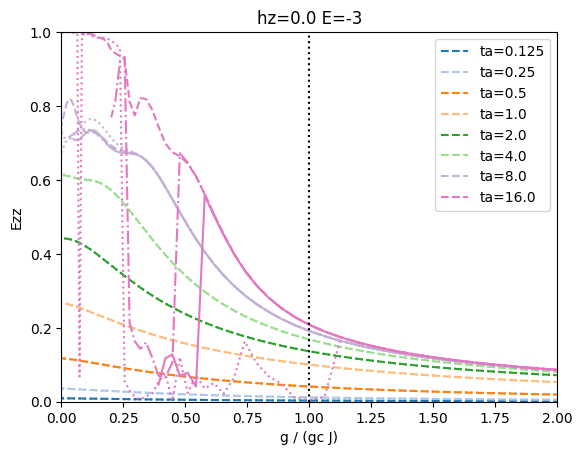

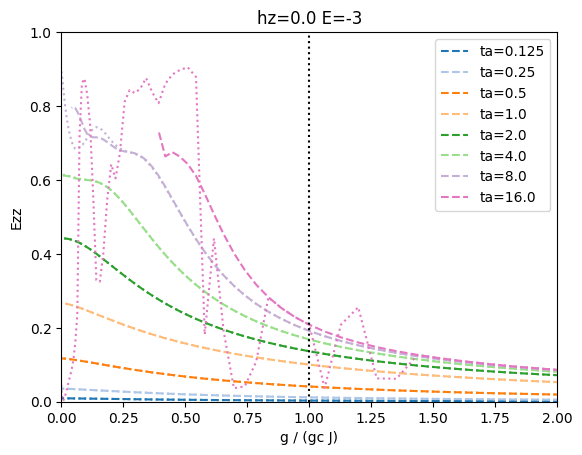

In [52]:
ax = plt.gca()
plot_ax(ax, 0.0, -1, val='Ezz', in_g=True)
ax.legend()
plt.show()
ax = plt.gca()
plot_ax(ax, 0.0, -2, val='Ezz', in_g=True)
ax.legend()
plt.show()
ax = plt.gca()
plot_ax(ax, 0.0, -3, val='Ezz', bb='XX', in_g=True)
ax.legend()
plt.show()
ax = plt.gca()
plot_ax(ax, 0.0, -3, val='Ezz', bb='ZZ', in_g=True)
ax.legend()
plt.show()

# ax.legend()
# plt.show()

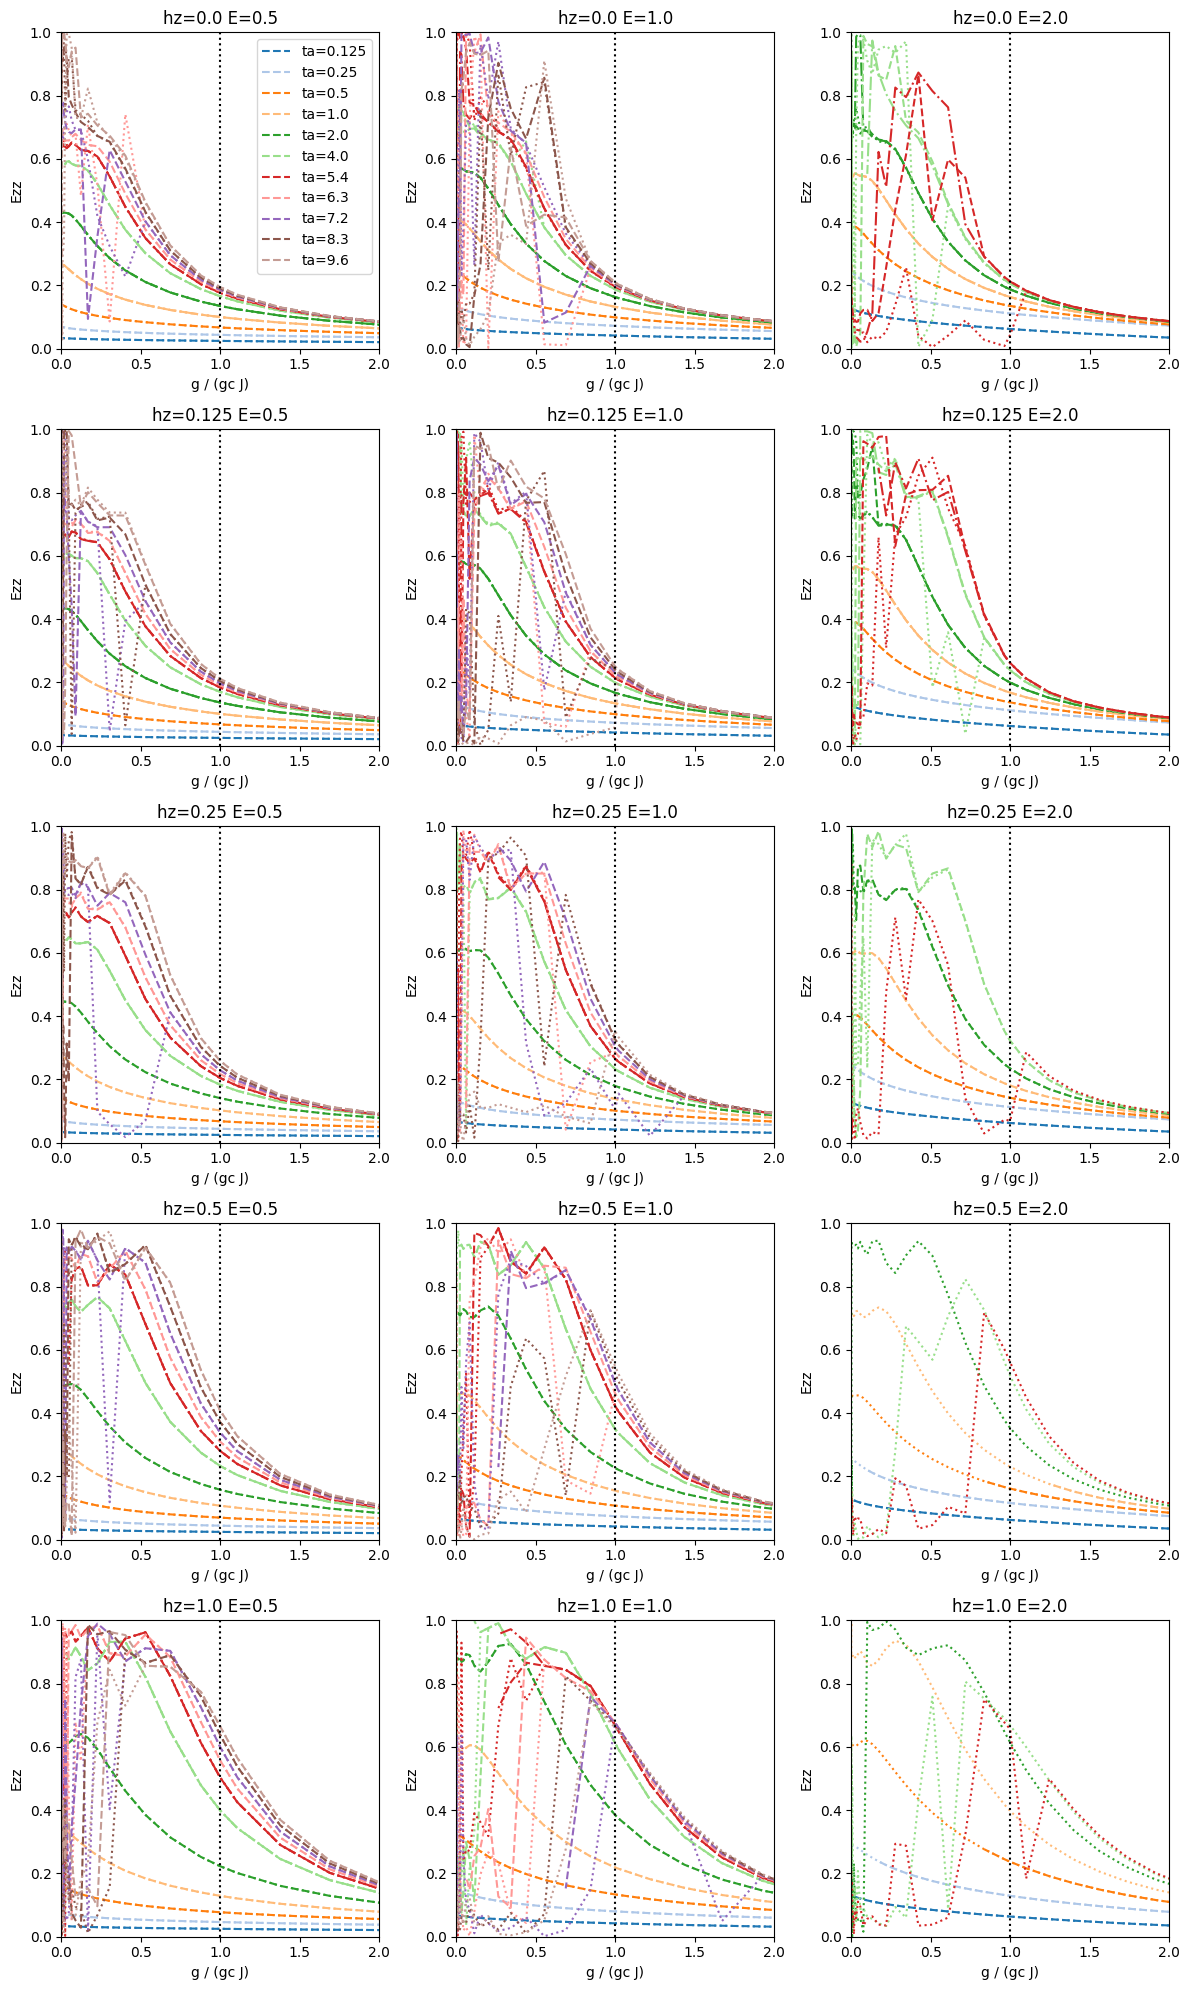

In [53]:
fig, axs = plt.subplots(5, 3)
fig.set_size_inches(12, 20)

for ii, hz in enumerate([0.0, 0.125, 0.25, 0.5, 1.0]):
    for jj, E in enumerate([0.5, 1.0, 2.0]):
        plot_ax(axs[ii, jj], hz, E, val='Ezz', in_g=True)
axs[0, 0].legend()

fig.tight_layout()


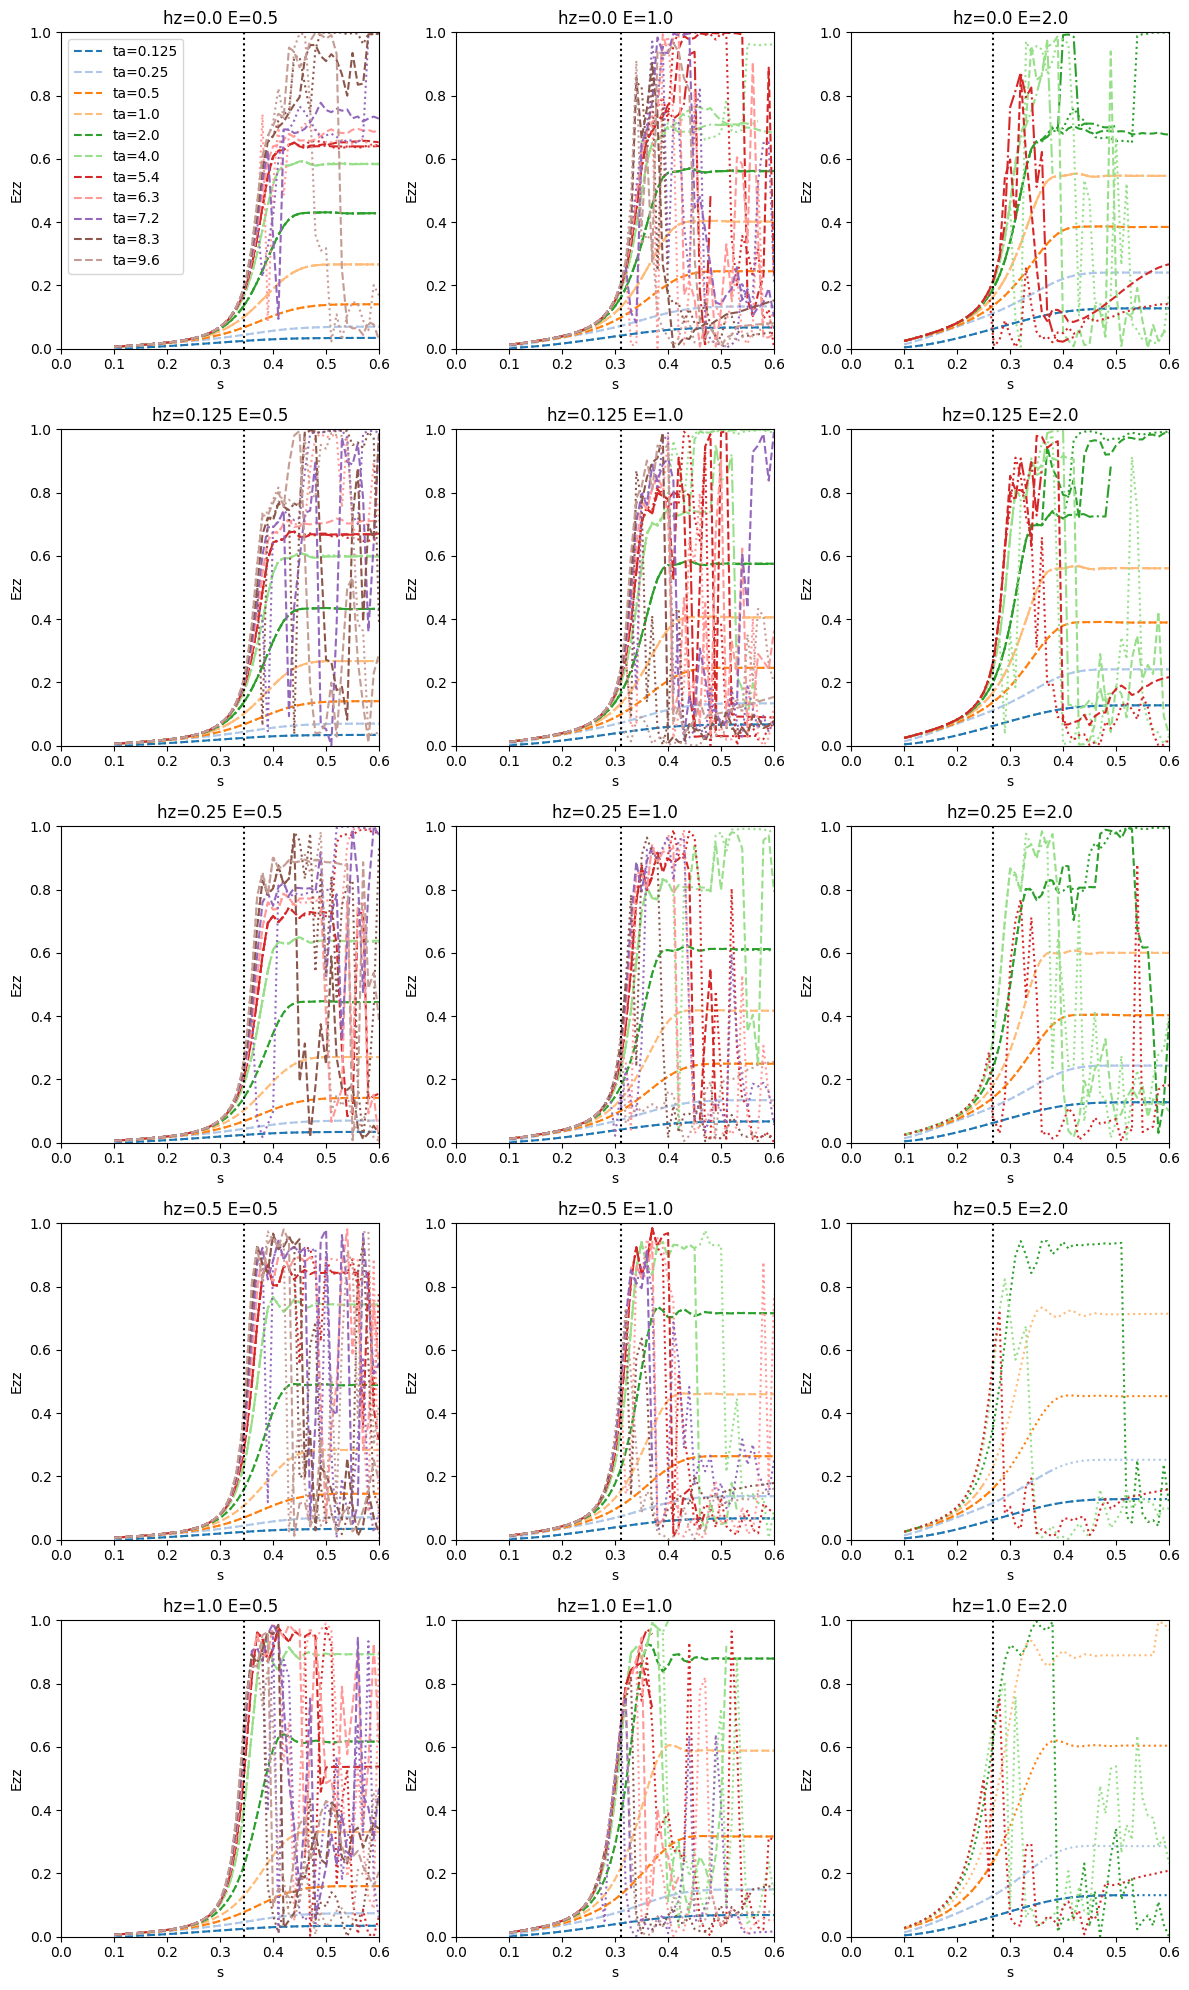

In [54]:
fig, axs = plt.subplots(5, 3)
fig.set_size_inches(12, 20)

for ii, hz in enumerate([0.0, 0.125, 0.25, 0.5, 1.0]):
    for jj, E in enumerate([0.5, 1.0, 2.0]):
        plot_ax(axs[ii, jj], hz, E, val='Ezz')
axs[0, 0].legend()

fig.tight_layout()


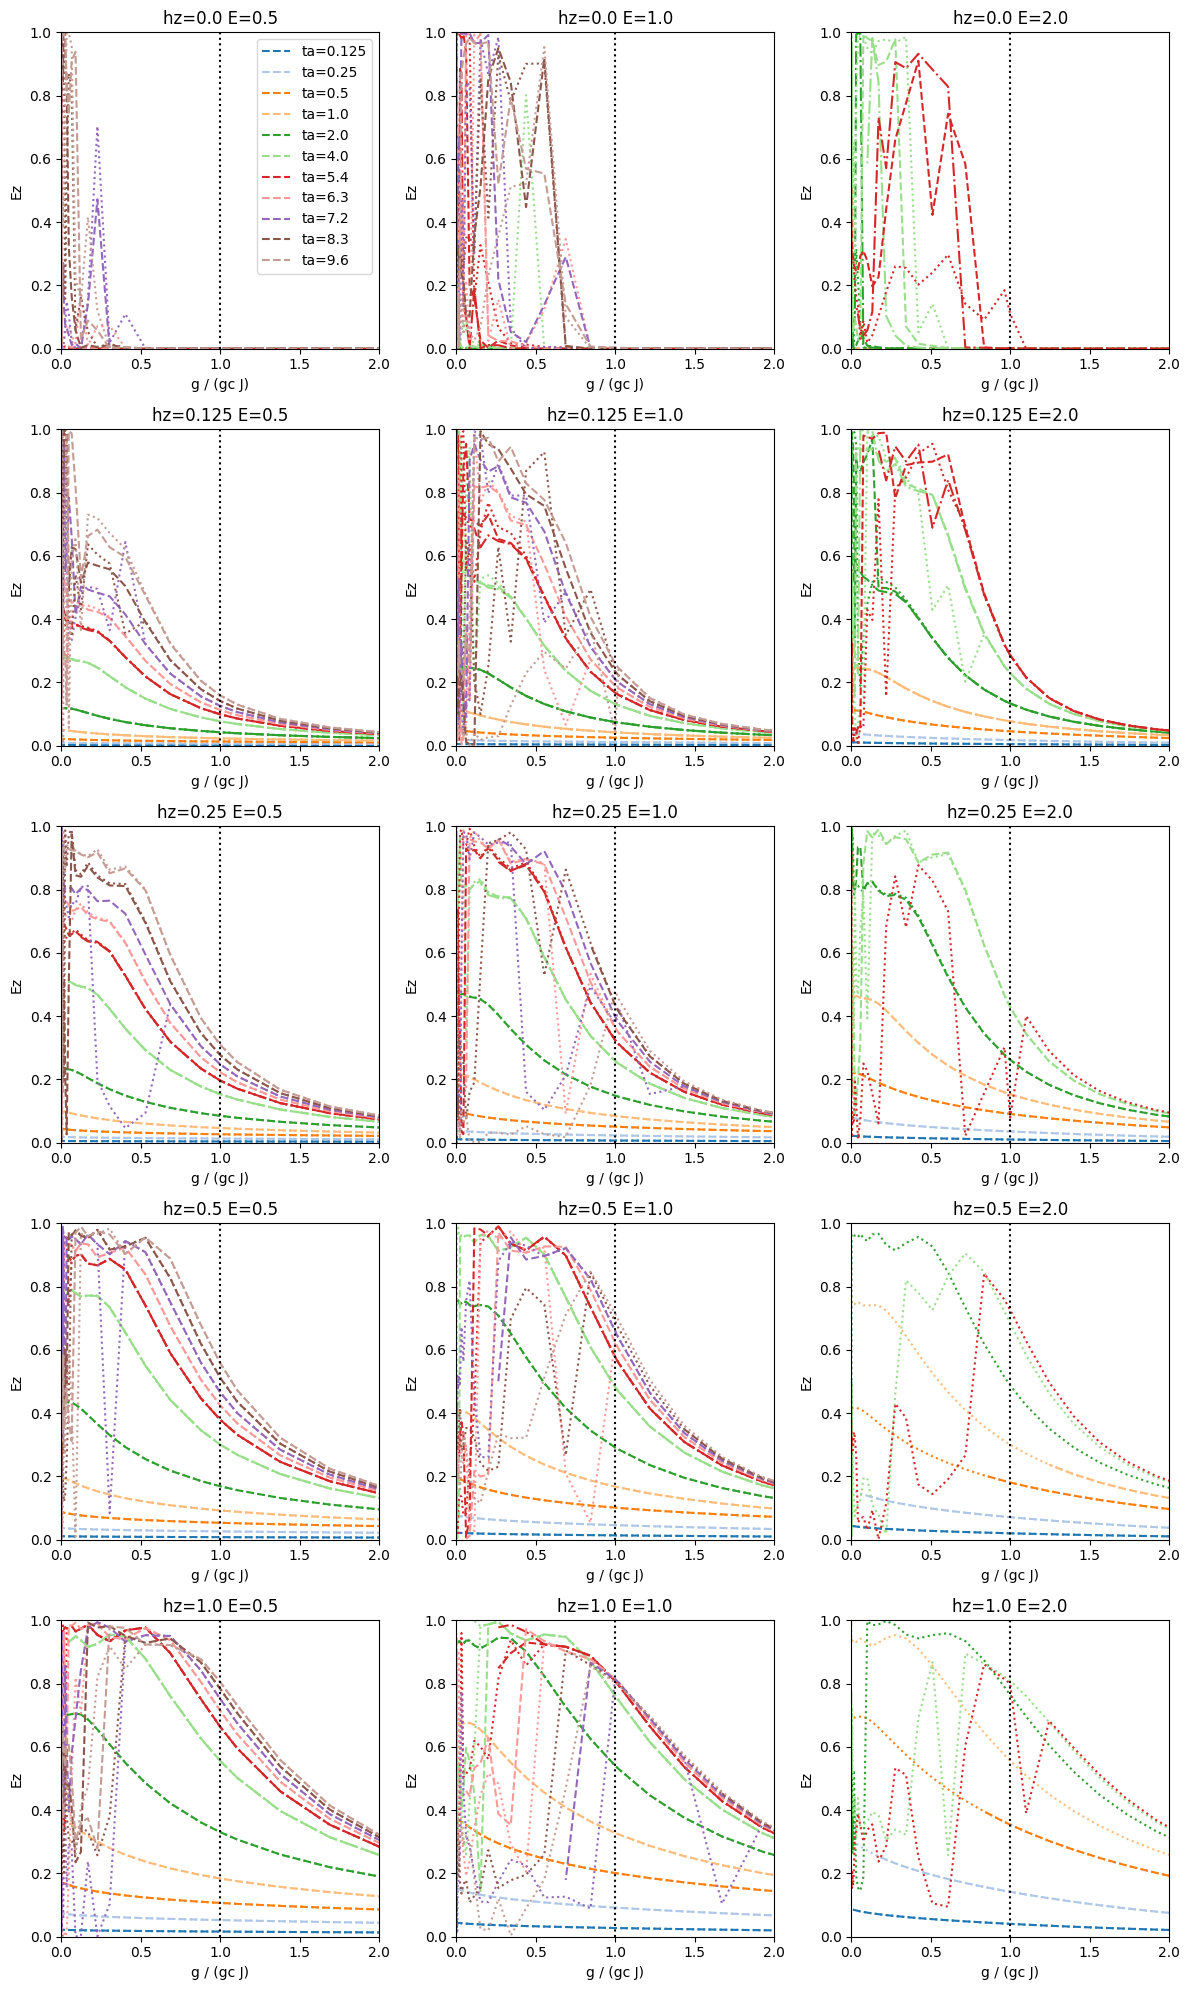

In [55]:
fig, axs = plt.subplots(5, 3)
fig.set_size_inches(12, 20)

for ii, hz in enumerate([0.0, 0.125, 0.25, 0.5, 1.0]):
    for jj, E in enumerate([0.5, 1.0, 2.0]):
        plot_ax(axs[ii, jj], hz, E, val='Ez', in_g=True)
axs[0, 0].legend()

fig.tight_layout()


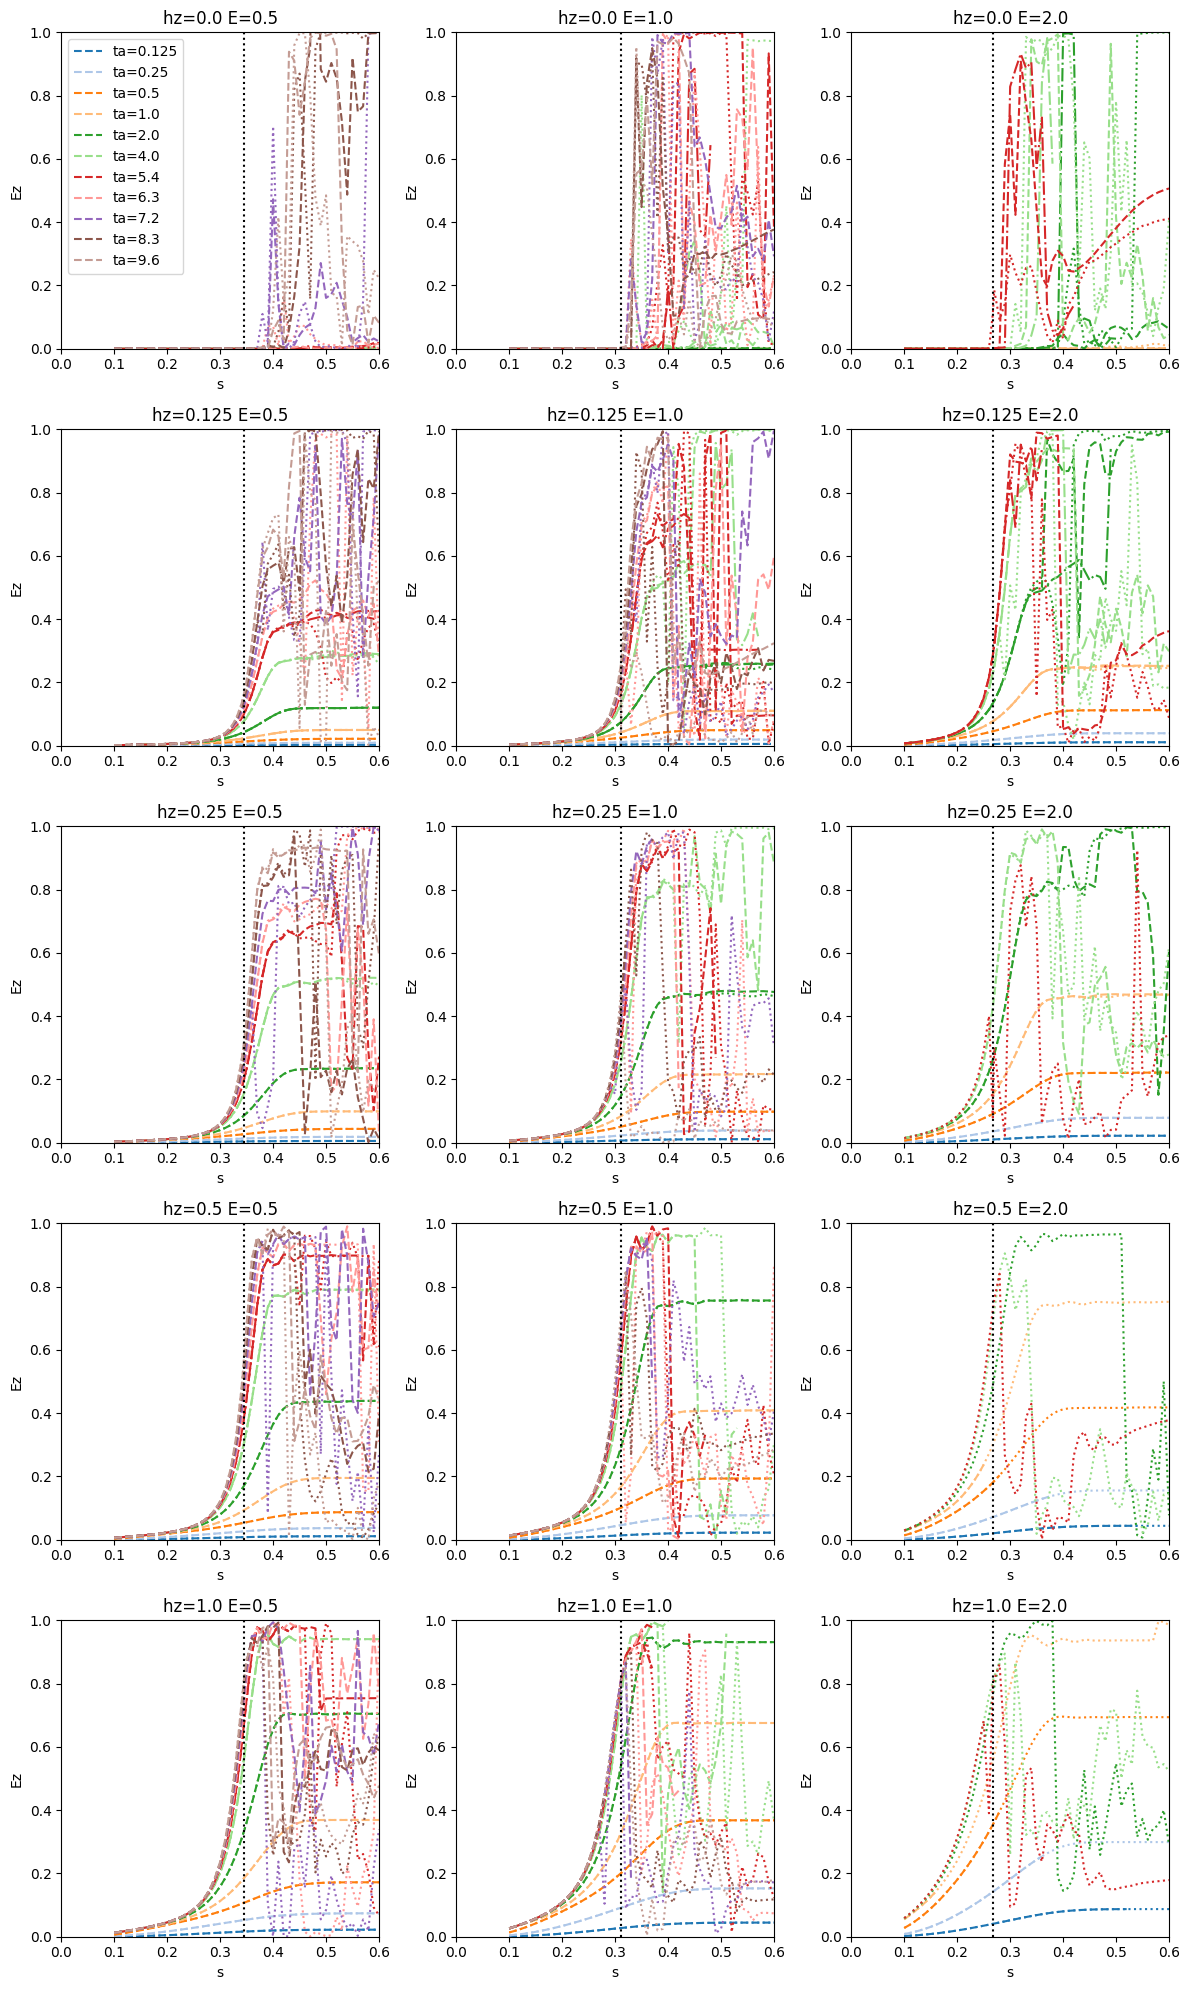

In [56]:
fig, axs = plt.subplots(5, 3)
fig.set_size_inches(12, 20)

for ii, hz in enumerate([0.0, 0.125, 0.25, 0.5, 1.0]):
    for jj, E in enumerate([0.5, 1.0, 2.0]):
        plot_ax(axs[ii, jj], hz, E, val='Ez')
axs[0, 0].legend()
fig.tight_layout()

In [37]:
data_zz = {}
for fname in glob.glob("./bias_dwave/**/Ezzs*.csv", recursive=True):
    param = fname.split("/")
    hz = float(param[2][3:])
    ta = float(param[3][3:])
    E = float(param[4][2:])
    bb = param[5]
    sf = float(param[6][8:14])
    ind = (hz, ta, E, sf, bb)


    with open(fname, 'r', newline='') as csvfile:
        for row in csv.DictReader(csvfile, delimiter=';'):
            if None in row:
                row.pop(None)
            for k, v in row.items():
                if k in ["D", 'chi']:
                    row[k] = int(v)
                elif k is not None and 'Ezz' in k:
                    row[k] = float(v)

            aa = {int(k[4:]): v for k, v in row.items() if 'Ezz_' in k}
            aa = dict(sorted(aa.items()))
            if (row['D'], row['which'], row['chi']) == (12, 'NN+BP', 16):
                data_zz[ind] = list(aa.values())

        # for x in csv.DictReader(csvfile, fieldnames=fieldnames, delimiter=";"):
        #     for fn, typ in zip(fieldnames, dtypes):
        #         x[fn] = typ(x[fn])
        #     x["Eng"] = (-2 * x["Ezz"] - float(hz) * x["Ez"])
        #     data[ind].append(x)

(1e-15, 1)

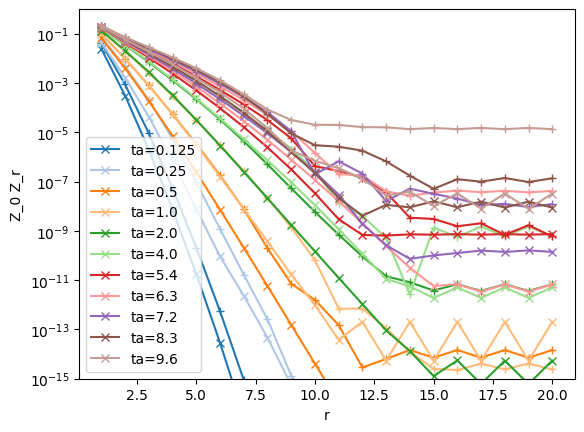

In [57]:
cm = sns.color_palette("tab20")


tas = [0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 5.4, 6.3, 7.2, 8.0, 8.3, 9.6]
for i, ta in enumerate(tas):
    try:
        ind = (0.0, ta, 0.5, 0.3445, 'ZZ')
        v = data_zz[ind]
        plt.semilogy(np.arange(20) + 1, np.abs(v), '-x', color=cm[i], label=f"ta={ta}")
        #
        ind = (0.0, ta, 1.0, 0.3112, 'ZZ')
        v = data_zz[ind]
        plt.semilogy(np.arange(20) + 1, np.abs(v), '-+', color=cm[i])
        #
    except KeyError:
        pass
plt.legend()
plt.xlabel('r')
plt.ylabel('Z_0 Z_r')
# plt.title('1-exp(-40*s) critical point')
plt.ylim([1e-15, 1])

(1e-15, 1)

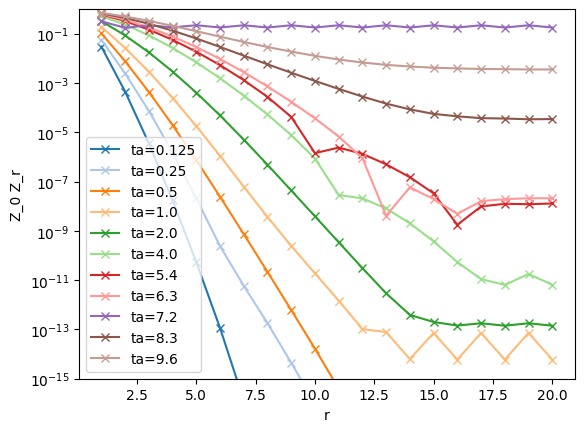

In [58]:
cm = sns.color_palette("tab20")
tas = [0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 5.4, 6.3, 7.2, 8.0, 8.3, 9.6]

for i, ta in enumerate(tas):
    try:
        ind = (0.0, ta, 0.5, 0.4, 'ZZ')
        v = data_zz[ind]
        plt.semilogy(np.arange(20) + 1, np.abs(v), '-x', color=cm[i], label=f"ta={ta}")
        #
        # ind = ('0.0000', ta, '1.0', '0.3112')
        # v = data_zz[ind]
        # plt.semilogy(np.arange(20) + 1, np.abs(v), '-+', color=cm[i])
        #
    except KeyError:
        pass
plt.legend()
plt.xlabel('r')
plt.ylabel('Z_0 Z_r')
# plt.title('1-exp(-40*s) critical point')
plt.ylim([1e-15, 1])

In [87]:
# Flood fill with periodic boundary conditions
def floodFill(image, x, y, newChar, oldChar=None, HEIGHT = 0, WIDTH=0):
    if oldChar is None:
        oldChar = image[y][x]
    if oldChar == newChar or image[y][x] != oldChar:
        return
    stack = [(x, y)]
    while stack:
        x, y = stack.pop()
        if image[y][x] == oldChar:
            image[y][x] = newChar
            stack.append(((x + 1) % WIDTH, y))
            stack.append(((x - 1) % WIDTH, y))
            stack.append((x, (y + 1) % HEIGHT))
            stack.append((x, (y - 1) % HEIGHT))

def loops(image):
    HEIGHT, WIDTH = image.shape
    domain_sizes = []
    domain_nr = 0
    oldChar = 0
    for y, row in enumerate(image):
        for x, val in enumerate(row):
            if val == oldChar:
                domain_nr += 1
                floodFill(image, x, y, domain_nr, oldChar=oldChar, HEIGHT = HEIGHT, WIDTH=WIDTH)
                domain_sizes.append(np.sum(image == domain_nr))
    return np.array(domain_sizes).astype(int)

# Analyze configuration
def analyze_spin_configuration(spin_config):
    HEIGHT, WIDTH = spin_config.shape
    domain_sizes = []
    spin_config = (-(spin_config-1)/2).astype(int) - 1
    domain_sizes.extend(loops(spin_config))
    # print(domain_sizes)
    area_counts = Counter(domain_sizes)
    A_vals = np.array(sorted(area_counts))
    P_A_vals = np.array([area_counts[a] / (HEIGHT * WIDTH) for a in A_vals])
    return A_vals, P_A_vals

In [41]:
def plot_sample(E, hz):

    if E == 0.5:
        sfs = [0.3445, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40]
    elif E == 1.0:
        sfs = [0.3112, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40]


    fig, axs = plt.subplots(3, len(sfs))
    fig.set_size_inches(3 * len(sfs), 9)

    tas = [2.0, 4.0, 5.4]
    for i, sf in enumerate(sfs):
        for j, ta in enumerate(tas):
            try:
                ttt = smpls[(hz, ta, E, sf, 12, 16, '32x32')]
                axs[j, i].imshow(ttt[0], cmap='bwr', interpolation='nearest')
                axs[j, i].axis('off')
                #ta = float(ta)
                #sf = float(sf)
                axs[j, i].set_title(f"{ta=} {sf=}")
                #print(sf, ta, np.sum(ttt) / (32 * 32))
            except:
                pass
    E = float(E)
    hz = float(hz)
    fig.suptitle(f"{hz=} {E=}", size=16)
    fig.tight_layout()
    fig.show()

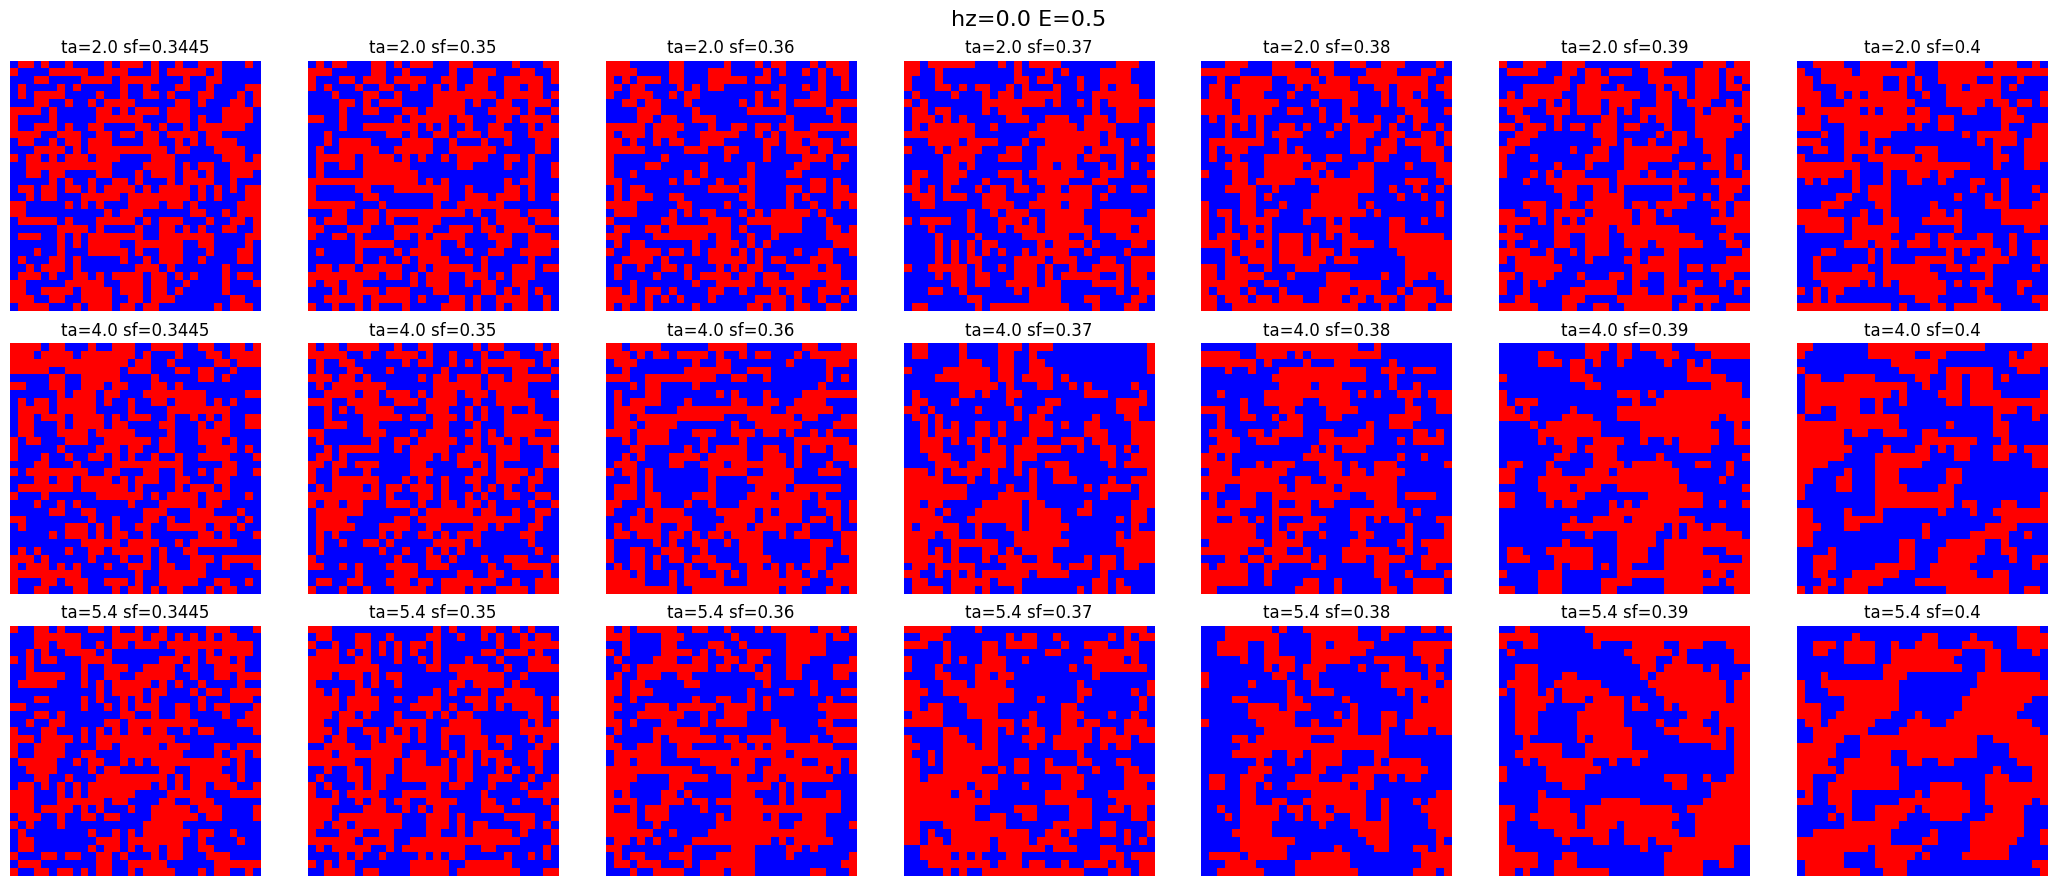

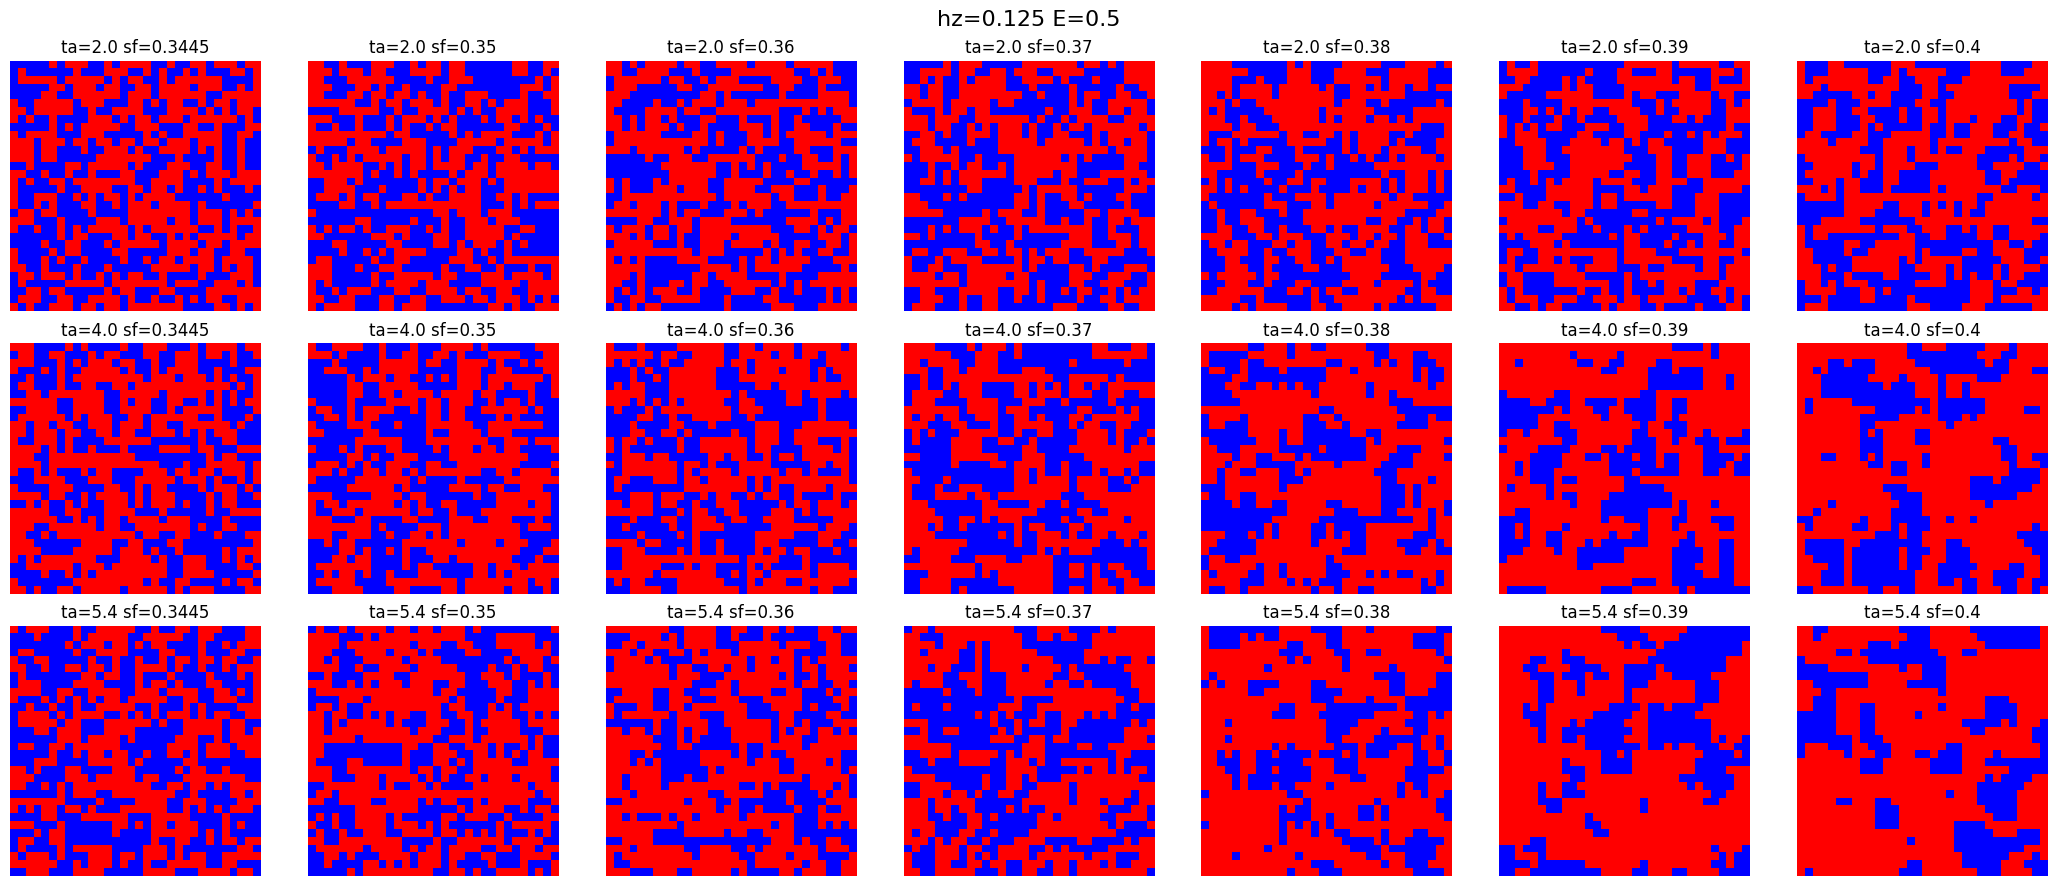

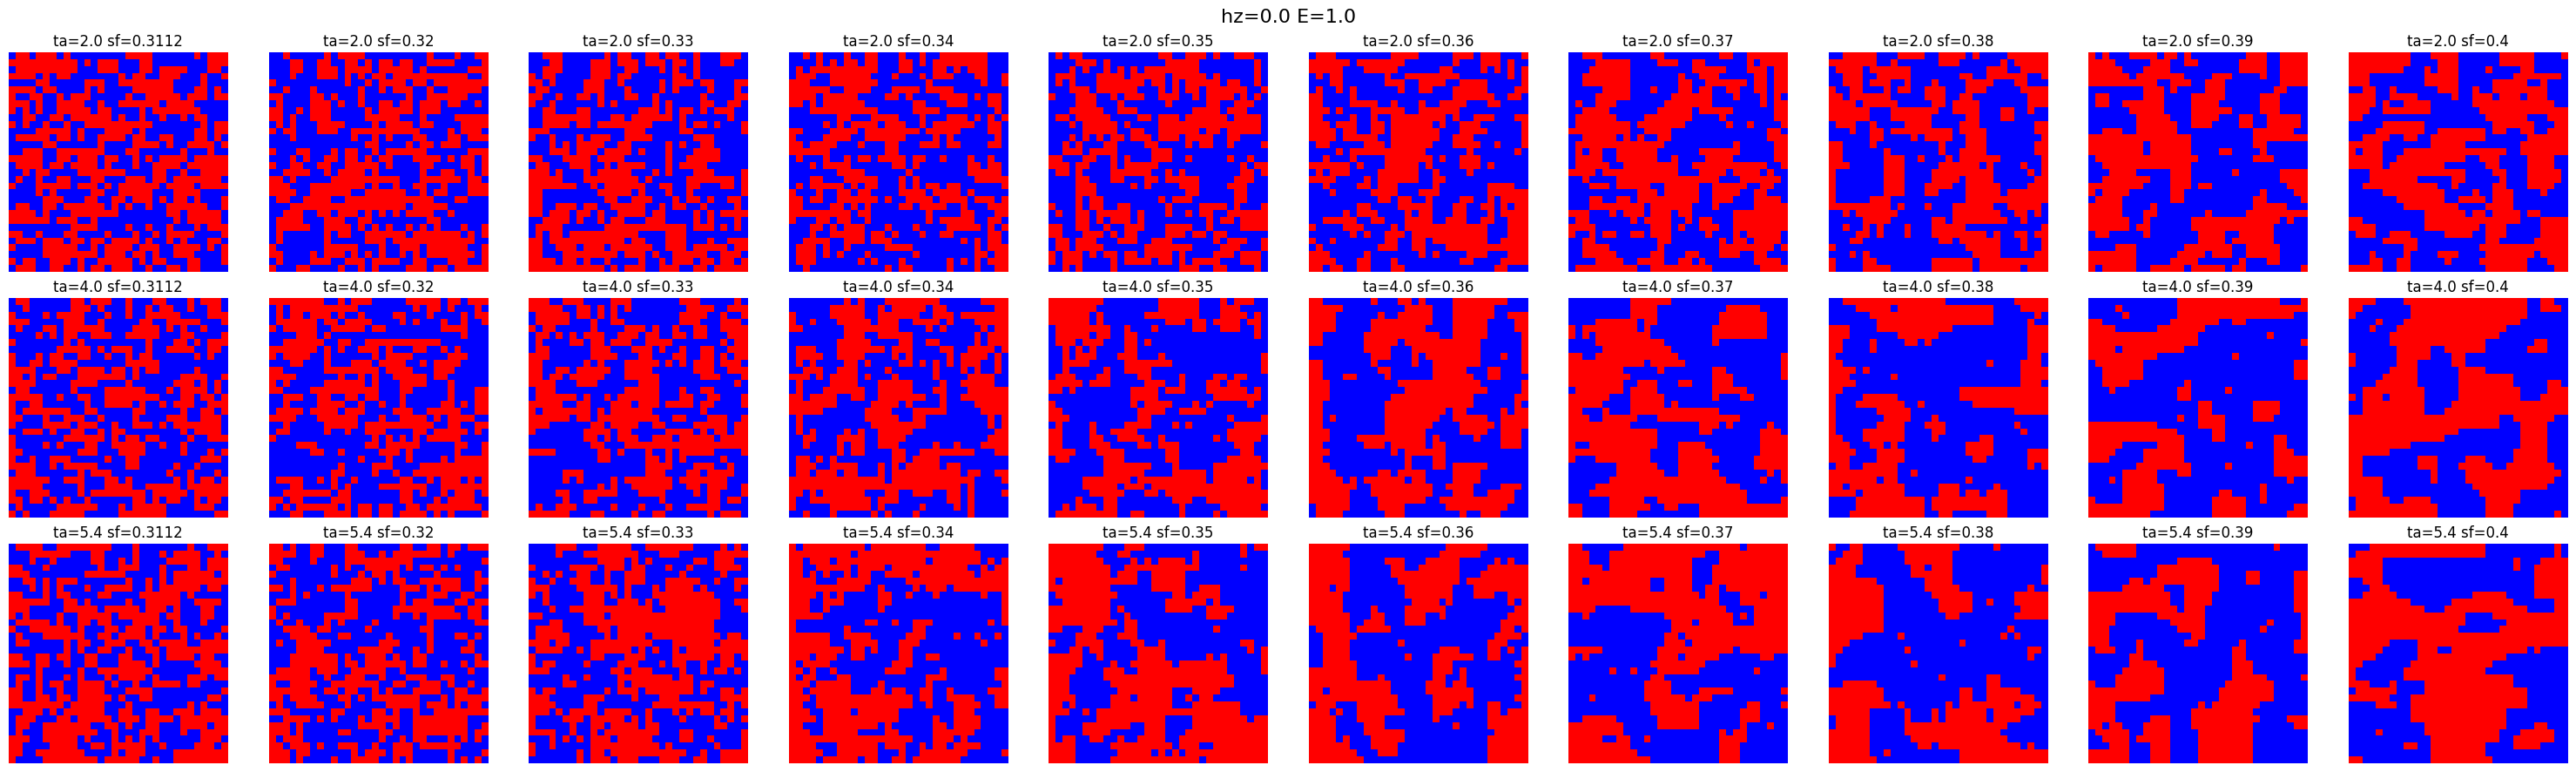

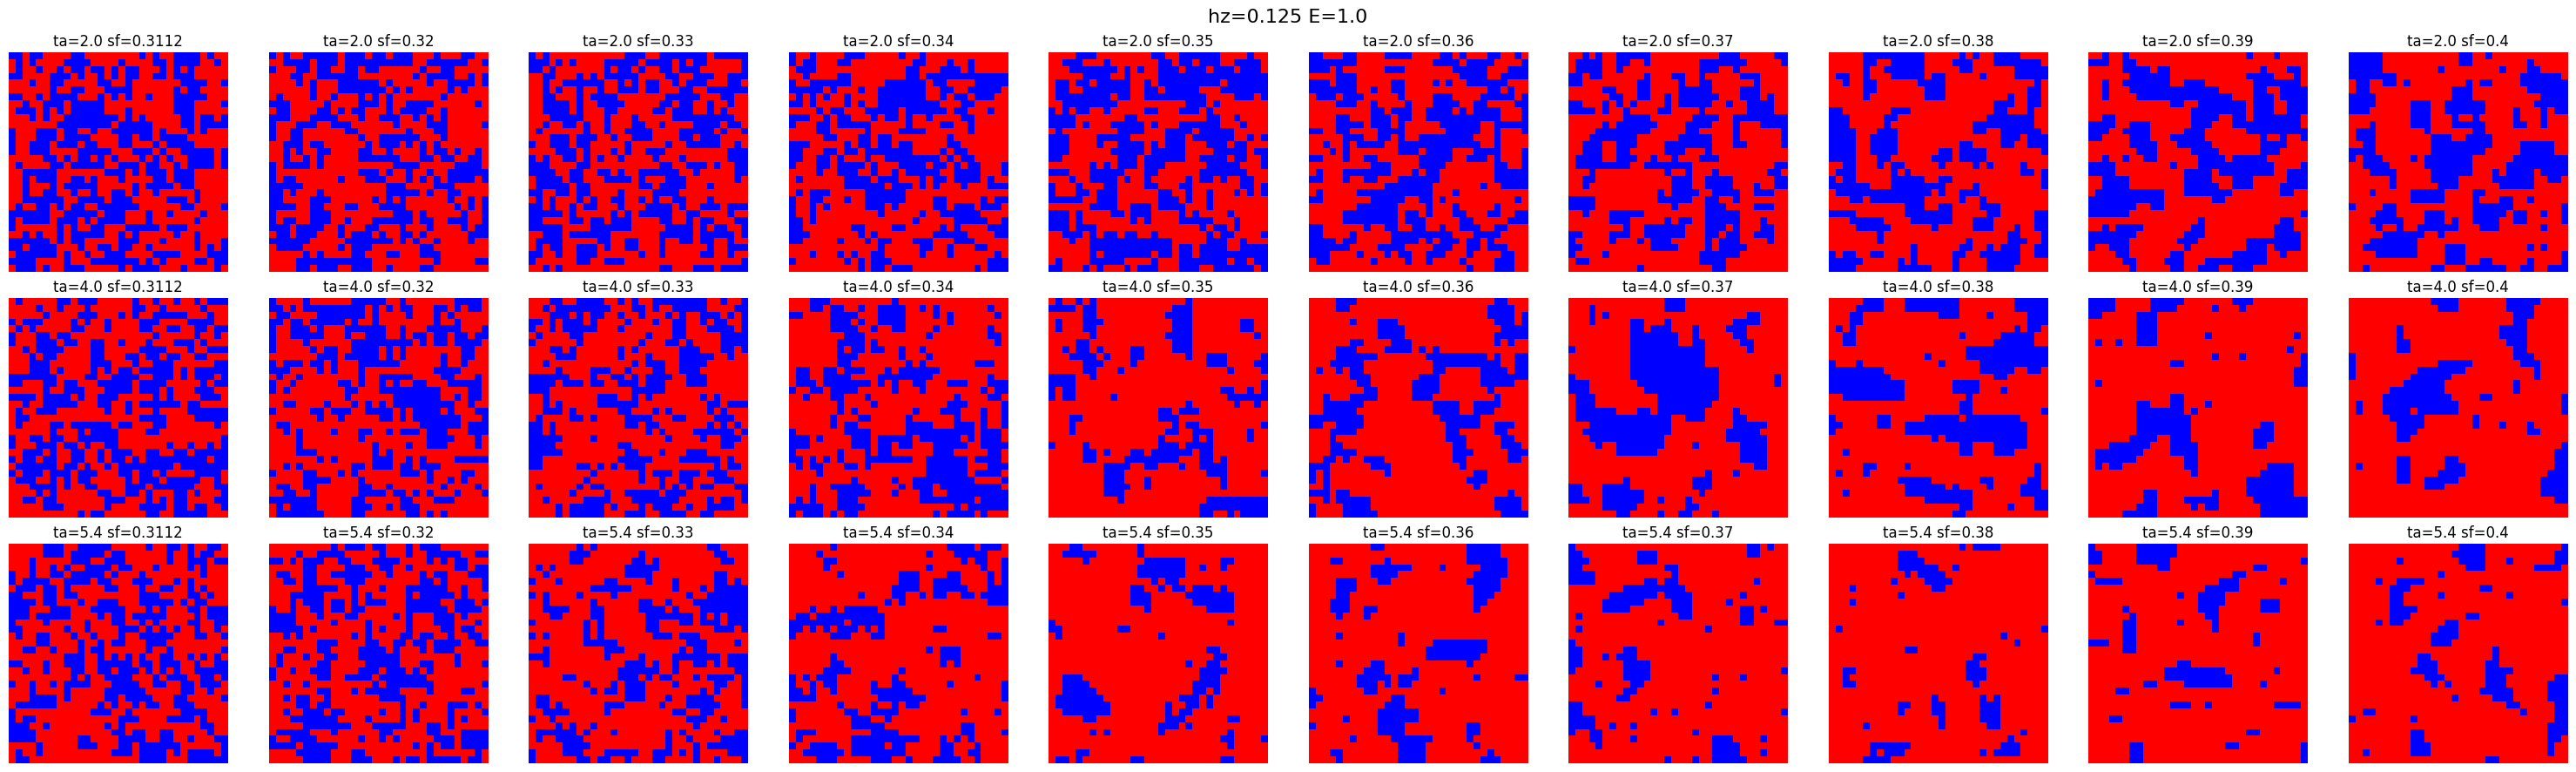

In [42]:
plot_sample(E=0.5, hz=0.000)
plot_sample(E=0.5, hz=0.125)
plot_sample(E=1.0, hz=0.000)
plot_sample(E=1.0, hz=0.125)

[np.int64(308), np.int64(1), np.int64(2), np.int64(3), np.int64(1), np.int64(1), np.int64(2), np.int64(3), np.int64(6), np.int64(4), np.int64(1), np.int64(2), np.int64(25), np.int64(1), np.int64(1), np.int64(3), np.int64(40), np.int64(21), np.int64(23), np.int64(2), np.int64(2), np.int64(2), np.int64(5), np.int64(1), np.int64(1), np.int64(13), np.int64(6), np.int64(1), np.int64(9), np.int64(1), np.int64(1), np.int64(5), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(1), np.int64(1), np.int64(5), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2)]


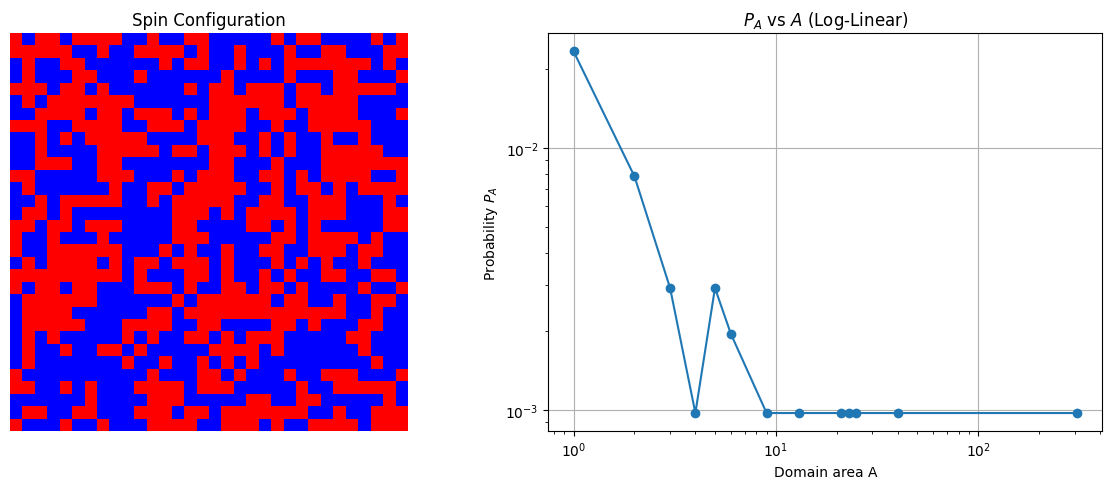

In [43]:
hz = 0.0
ta = 4.0
E  = 0.5
sf = 0.35
config = smpls[(hz, ta, E, sf, 12, 16, '32x32')][0]
A_vals, P_A_vals = analyze_spin_configuration(config)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(config, cmap='bwr', interpolation='nearest')
axs[0].set_title("Spin Configuration")
axs[0].axis('off')
axs[1].loglog(A_vals, P_A_vals, 'o-')
axs[1].set_xlabel("Domain area A")
axs[1].set_ylabel("Probability $P_A$")
axs[1].set_title("$P_A$ vs $A$ (Log-Linear)")
axs[1].grid(True)
plt.tight_layout()
plt.show()

In [68]:
for x, v in sorted(smpls.items()):
    print(x, v.shape)

(0.0, 2.0, 0.5, 0.3445, 12, 16, '16x16') (1, 16, 16)
(0.0, 2.0, 0.5, 0.3445, 12, 16, '32x32') (16, 32, 32)
(0.0, 2.0, 0.5, 0.3445, 12, 16, '64x64') (1, 64, 64)
(0.0, 2.0, 0.5, 0.35, 12, 16, '16x16') (1, 16, 16)
(0.0, 2.0, 0.5, 0.35, 12, 16, '32x32') (16, 32, 32)
(0.0, 2.0, 0.5, 0.35, 12, 16, '64x64') (1, 64, 64)
(0.0, 2.0, 0.5, 0.36, 12, 16, '16x16') (1, 16, 16)
(0.0, 2.0, 0.5, 0.36, 12, 16, '32x32') (16, 32, 32)
(0.0, 2.0, 0.5, 0.36, 12, 16, '64x64') (1, 64, 64)
(0.0, 2.0, 0.5, 0.37, 12, 16, '16x16') (1, 16, 16)
(0.0, 2.0, 0.5, 0.37, 12, 16, '32x32') (16, 32, 32)
(0.0, 2.0, 0.5, 0.37, 12, 16, '64x64') (1, 64, 64)
(0.0, 2.0, 0.5, 0.38, 12, 16, '16x16') (1, 16, 16)
(0.0, 2.0, 0.5, 0.38, 12, 16, '32x32') (16, 32, 32)
(0.0, 2.0, 0.5, 0.38, 12, 16, '64x64') (1, 64, 64)
(0.0, 2.0, 0.5, 0.39, 12, 16, '16x16') (1, 16, 16)
(0.0, 2.0, 0.5, 0.39, 12, 16, '32x32') (16, 32, 32)
(0.0, 2.0, 0.5, 0.39, 12, 16, '64x64') (1, 64, 64)
(0.0, 2.0, 0.5, 0.4, 12, 16, '16x16') (1, 16, 16)
(0.0, 2.0, 0.5, 0.4,

In [ ]:
def plot_sample(hz, ta, E, x='32x32', D=12, chi=16):

    sss = sorted([ t for t in smpls if t[:3] + t[4:] == (hz, ta, E, D, chi, x)])
    sfs = [t[3] for t in sss]

    ttt = smpls[sss[0]]
    ns = 1

    fig, axs = plt.subplots(ns, len(sss), squeeze=False)
    fig.set_size_inches(len(sss)*3, 3*ns)

    for ii, tt in enumerate(sss):
        for jj in range(ns):
            ttt = smpls[tt]
            axs[jj, ii].imshow(ttt[jj], cmap='bwr', interpolation='nearest')
            axs[jj, ii].axis('off')
            axs[jj, ii].set_title(f"s={tt[3]}")
    E = float(E)
    hz = float(hz)
    fig.suptitle(f"{hz=} {E=} {ta=}", size=16)
    fig.tight_layout()
    fig.show()

In [ ]:
def accumulate_PA(hz, ta, E, x='32x32', D=12, chi=16):

    sss = sorted([ t for t in smpls if t[:3] + t[4:] == (hz, ta, E, D, chi, x)])
    sfs = [t[3] for t in sss]

    fig, axs = plt.subplots(1, len(sss))
    fig.set_size_inches(len(sss)*3, 3)


    for ii, tt in enumerate(sss):
        ttt = smpls[tt]
        ns = len(ttt)
        PA = {}
        for jj in range(ns):
            A_vals, P_A_vals = analyze_spin_configuration(ttt[jj])
            for k, v in zip(A_vals, P_A_vals):
                if k in PA:
                    PA[k] += v
                else:
                    PA[k] = v
        for k, v in PA.items():
            PA[k] = v / ns

        PA = {k: PA[k] for k in sorted(PA)}
        Av = list(PA.keys())
        PAv = list(PA.values())
        axs[ii].loglog(Av, PAv, 'o-')
        axs[ii].set_title(f"s={tt[3]}")
        axs[ii].set_xlim([1, 1000])
        axs[ii].set_ylim([1e-4, 1e-1])


fig.suptitle(f"{hz=} {E=} {ta=}", size=16)
fig.tight_layout()
fig.show()

AttributeError: 'Axes' object has no attribute 'xlim'

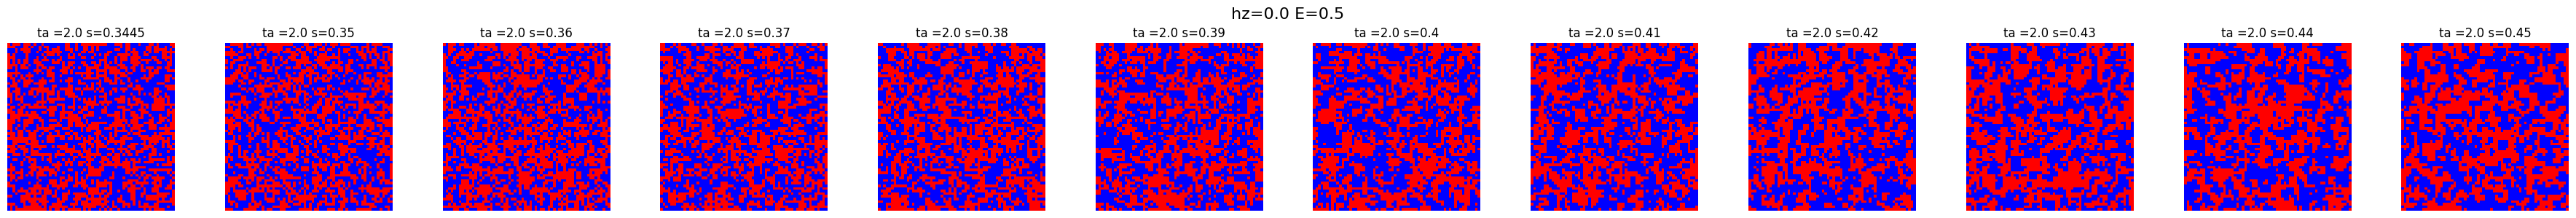

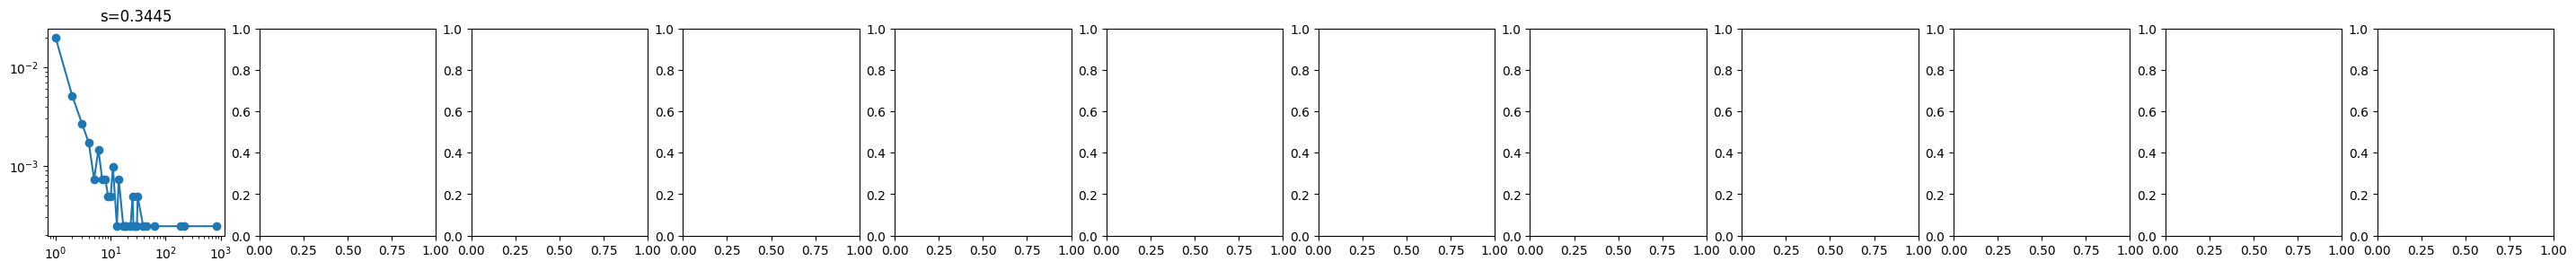

In [100]:
plot_sample(hz=0.0, ta=2.0, E=0.5, x='64x64', D=12, chi=16)
accumulate_PA(hz=0.0, ta=2.0, E=0.5, x='64x64', D=12, chi=16)

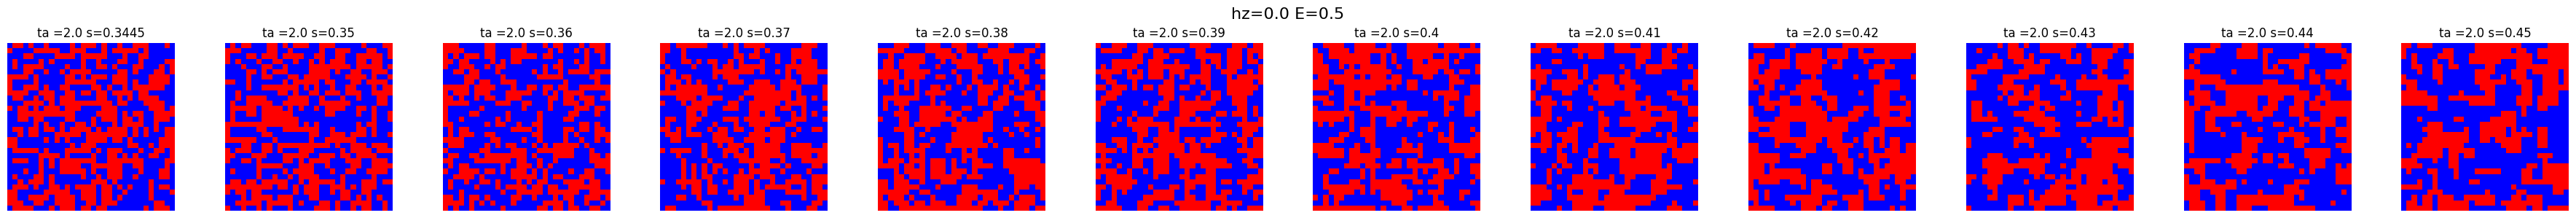

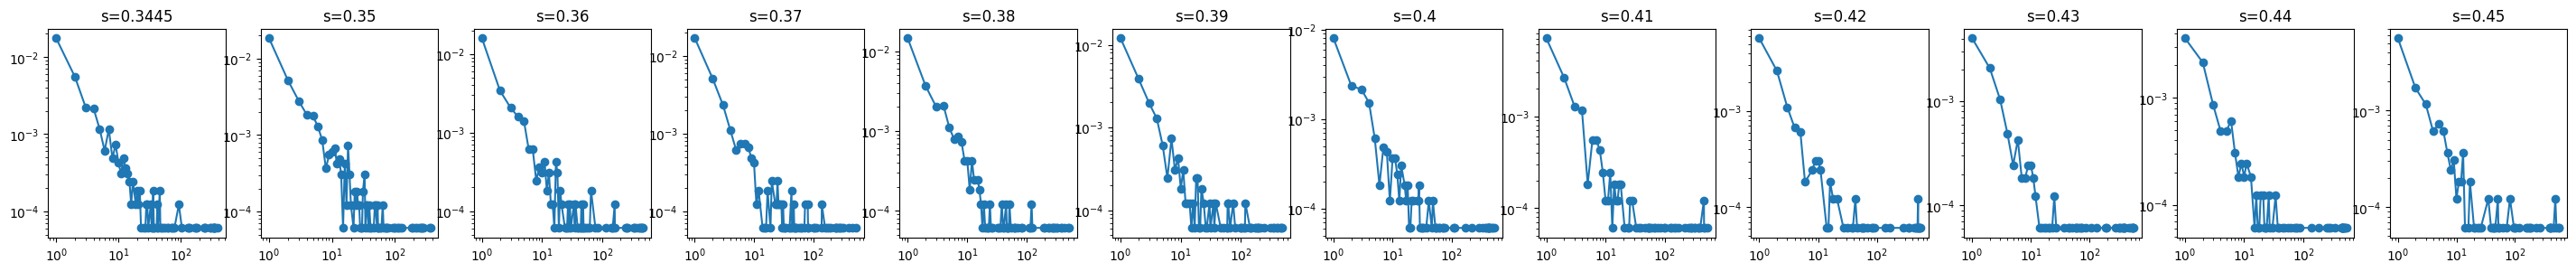

In [98]:
plot_sample(hz=0.0, ta=2.0, E=0.5, x='32x32', D=12, chi=16)
accumulate_PA(hz=0.0, ta=2.0, E=0.5, x='32x32', D=12, chi=16)